In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### Data Set Information:

The experiments have been carried out by means of a numerical simulator of a naval vessel (Frigate) characterized by a Gas Turbine (GT) propulsion plant. The different blocks forming the complete simulator (Propeller, Hull, GT, Gear Box and Controller) have been developed and fine tuned over the year on several similar real propulsion plants. In view of these observations the available data are in agreement with a possible real vessel.
In this release of the simulator it is also possible to take into account the performance decay over time of the GT components such as GT compressor and turbines.
The propulsion system behaviour has been described with this parameters:
- Ship speed (linear function of the lever position lp).
- Compressor degradation coefficient kMc.
- Turbine degradation coefficient kMt.
so that each possible degradation state can be described by a combination of this triple (lp,kMt,kMc).
The range of decay of compressor and turbine has been sampled with an uniform grid of precision 0.001 so to have a good granularity of representation.
In particular for the compressor decay state discretization the kMc coefficient has been investigated in the domain [1; 0.95], and the turbine coefficient in the domain [1; 0.975].
Ship speed has been investigated sampling the range of feasible speed from 3 knots to 27 knots with a granularity of representation equal to tree knots.
A series of measures (16 features) which indirectly represents of the state of the system subject to performance decay has been acquired and stored in the dataset over the parameter's space.


### Attribute Information:

- A 16-feature vector containing the GT measures at steady state of the physical asset:
- Lever position (lp) [ ]
- Ship speed (v) [knots]
- Gas Turbine (GT) shaft torque (GTT) [kN m]
- GT rate of revolutions (GTn) [rpm]
- Gas Generator rate of revolutions (GGn) [rpm]
- Starboard Propeller Torque (Ts) [kN]
- Port Propeller Torque (Tp) [kN]
- Hight Pressure (HP) Turbine exit temperature (T48) [C]
- GT Compressor inlet air temperature (T1) [C]
- GT Compressor outlet air temperature (T2) [C]
- HP Turbine exit pressure (P48) [bar]
- GT Compressor inlet air pressure (P1) [bar]
- GT Compressor outlet air pressure (P2) [bar]
- GT exhaust gas pressure (Pexh) [bar]
- Turbine Injecton Control (TIC) [%]
- Fuel flow (mf) [kg/s]
-----------------------------
Want we want to predict is:
- GT Compressor decay state coefficient
- GT Turbine decay state coefficient

In [2]:
columns = ['lever_position', 'ship_speed', 'gt_shaft', 'gt_rate', 'gg_rate', 'sp_torque', 'pp_torque', \
                    'hpt_temp', 'gt_c_i_temp', 'gt_c_o_temp', 'hpt_pressure', 'gt_c_i_pressure', 'gt_c_o_pressure', \
                    'gt_exhaust_pressure', 'turbine_inj_control', 'fuel_flow', 'gt_c_decay',  'gt_t_decay']

df = pd.read_table('./datasets/data.txt',delim_whitespace=True,names=columns)

In [3]:
df.head()

,lever_position,ship_speed,gt_shaft,gt_rate,gg_rate,sp_torque,pp_torque,hpt_temp,gt_c_i_temp,gt_c_o_temp,hpt_pressure,gt_c_i_pressure,gt_c_o_pressure,gt_exhaust_pressure,turbine_inj_control,fuel_flow,gt_c_decay,gt_t_decay
0,1.138,3.0,289.964,1349.489,6677.380,7.584,7.584,464.006,288.0,550.563,1.096,0.998,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6.0,6960.180,1376.166,6828.469,28.204,28.204,635.401,288.0,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9.0,8379.229,1386.757,7111.811,60.358,60.358,606.002,288.0,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12.0,14724.395,1547.465,7792.630,113.774,113.774,661.471,288.0,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15.0,21636.432,1924.313,8494.777,175.306,175.306,731.494,288.0,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.95,0.975


Παρατηρούμε ότι δεν έχουμε missing values.

In [4]:
df.isna().sum()

lever_position         0
ship_speed             0
gt_shaft               0
gt_rate                0
gg_rate                0
sp_torque              0
pp_torque              0
hpt_temp               0
gt_c_i_temp            0
gt_c_o_temp            0
hpt_pressure           0
gt_c_i_pressure        0
gt_c_o_pressure        0
gt_exhaust_pressure    0
turbine_inj_control    0
fuel_flow              0
gt_c_decay             0
gt_t_decay             0
dtype: int64

In [5]:
df.nunique()

lever_position             9
ship_speed                 9
gt_shaft               11430
gt_rate                 3888
gg_rate                11834
sp_torque               4286
pp_torque               4286
hpt_temp               11772
gt_c_i_temp                1
gt_c_o_temp            11506
hpt_pressure             524
gt_c_i_pressure            1
gt_c_o_pressure         4209
gt_exhaust_pressure       19
turbine_inj_control     8496
fuel_flow                696
gt_c_decay                51
gt_t_decay                26
dtype: int64

Βλέπουμε εδώ ότι οι στήλες `gt_c_i_temp` και `gt_c_i_pressure` έχουν μόνο μια μοναδική τιμή οπότε τις αφήνουμε.

In [5]:
df = df.drop(columns=['gt_c_i_temp','gt_c_i_pressure'])

In [6]:
df.head()

,lever_position,ship_speed,gt_shaft,gt_rate,gg_rate,sp_torque,pp_torque,hpt_temp,gt_c_o_temp,hpt_pressure,gt_c_o_pressure,gt_exhaust_pressure,turbine_inj_control,fuel_flow,gt_c_decay,gt_t_decay
0,1.138,3.0,289.964,1349.489,6677.380,7.584,7.584,464.006,550.563,1.096,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6.0,6960.180,1376.166,6828.469,28.204,28.204,635.401,581.658,1.331,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9.0,8379.229,1386.757,7111.811,60.358,60.358,606.002,587.587,1.389,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12.0,14724.395,1547.465,7792.630,113.774,113.774,661.471,613.851,1.658,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15.0,21636.432,1924.313,8494.777,175.306,175.306,731.494,645.642,2.078,11.197,1.026,26.373,0.522,0.95,0.975


Correlation Matrix

<AxesSubplot:>

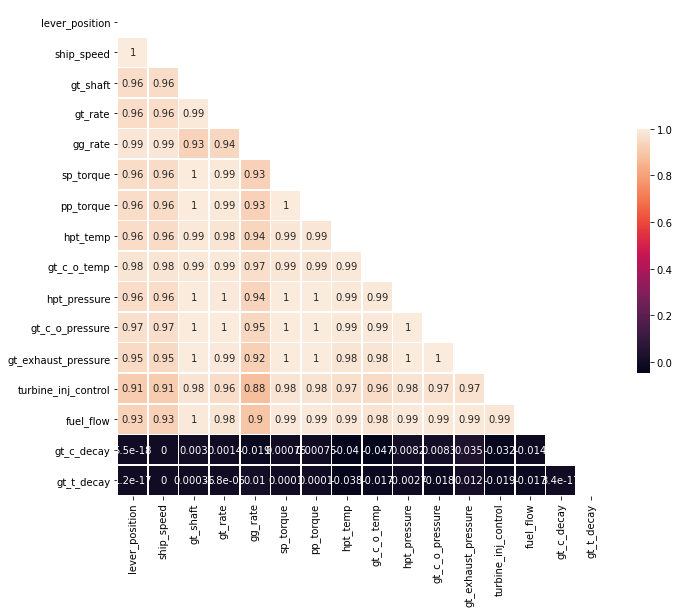

In [7]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True,yticklabels = df.columns.values, xticklabels=df.columns.values)

### Train-Test-Split (80\% Train - 20\% Test) and Min-Max Scaling

Πρώτα εκτελούμε το διαχωρισμό test-train και μετά το min-max scaling ώστε να μην έχουμε διαρροή πληροφορίας από το test set μέσα στο train set (π.χ. πληροφορία από το μέσο όρο).

In [33]:
df.shape

(11934, 16)

In [57]:
X = df.drop(columns=['gt_c_decay','gt_t_decay'])
y = df[['gt_c_decay','gt_t_decay']]
print(X.shape)
print(y.shape)

(11934, 14)
(11934, 2)


In [58]:
X_train_unsc, X_test_unsc, y_train_unsc, y_test_unsc = train_test_split(X,y, test_size=0.3, random_state=75)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=75)

In [72]:
scaler_x = preprocessing.MinMaxScaler()
scaler_y = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler_x.fit_transform(X_train_unsc))
X_test = pd.DataFrame(scaler_x.fit_transform(X_test_unsc))
y_train = pd.DataFrame(scaler_y.fit_transform(y_train_unsc))
y_test = pd.DataFrame(scaler_y.fit_transform(y_test_unsc))

In [73]:
print('X train shape:',X_train.shape)
print('X test shape:',X_test.shape)
print('y train shape:',y_train.shape)
print('y test shape:',y_test.shape)

X train shape: (8353, 14)
X test shape: (3581, 14)
y train shape: (8353, 2)
y test shape: (3581, 2)


### Help function to compare models

In [19]:
#helper function to plot models in train and test sets for easier comparison
def compare_models(trainX,trainY,testX,testY,models):
    print('\nCompare Multiple Regressors:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    
    names = []
    tempdf = pd.DataFrame(columns=['Name','Dataset','Score','St.Dev'])
    for name, model in models:
        model.fit(trainX,trainY)
        kfold = KFold(n_splits=2,shuffle=True,random_state = 75)
        train_accuracy_results = cross_val_score(model, trainX,trainY, cv=kfold)
        test_accuracy_results = cross_val_score(model,testX,testY,cv=kfold)
        tempdf = tempdf.append({'Name':name,'Dataset':'Train','Score':train_accuracy_results.mean(),
                               'St.Dev':train_accuracy_results.std()},ignore_index=True)
        tempdf = tempdf.append({'Name':name,'Dataset':'Test','Score':test_accuracy_results.mean(),
                               'St.Dev':test_accuracy_results.std()},ignore_index=True)
    g = sns.catplot(x = 'Name', y='Score',hue = 'Dataset',data=tempdf, kind='bar',height=7.5, aspect=11.7/7.5)
    g.set_xticklabels(rotation=30)
    return tempdf,plt.show()

## Run Regressors with Default Hyperparameters

Καθώς το πρόβλημά μας έχει δύο μεταβλητές που πρέπει να προβλέψουμε, χρησιμοποιούμε από το scikit learn τον `Multi Output Regressor`, σαν wrapper για τους γνωστούς regressors.

In [74]:
models = []

Βάζουμε Random_Seed = 75 (team name) ώστε να αποτελέσματα να είναι reproducible. 

In [75]:
models.append(('MR-LR', MultiOutputRegressor(LinearRegression())))
models.append(('MR-RD', MultiOutputRegressor(Ridge())))
models.append(('MR-ELAS', MultiOutputRegressor(ElasticNet())))
models.append(('MR-DT', MultiOutputRegressor(DecisionTreeRegressor(random_state=75))))
models.append(('MR-KRI', MultiOutputRegressor(KernelRidge()) ))
models.append(('MR-kNN',MultiOutputRegressor(KNeighborsRegressor())))
models.append(('MR-ET',MultiOutputRegressor(ExtraTreesRegressor(random_state=75))))
models.append(('MR-RF',MultiOutputRegressor(RandomForestRegressor(random_state=75))))
models.append(('MR-XGB', MultiOutputRegressor(XGBRegressor(random_state=75))))


Compare Multiple Regressors:

K-Fold Cross-Validation Accuracy:



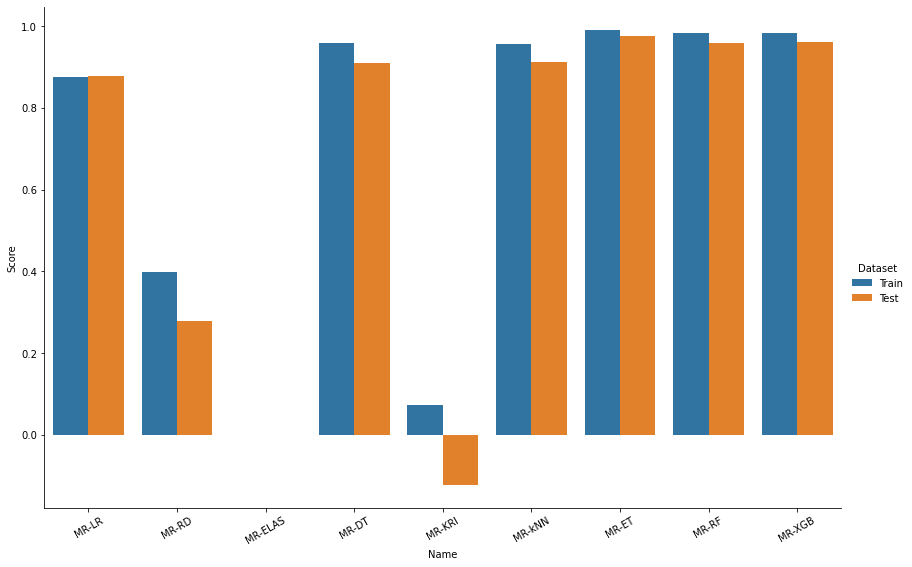

Wall time: 45.9 s


,Name,Dataset,Score,St.Dev
0,MR-LR,Train,0.875159,0.001638
1,MR-LR,Test,0.877114,0.000861
2,MR-RD,Train,0.397622,0.004964
3,MR-RD,Test,0.278085,0.007683
4,MR-ELAS,Train,-0.000578,0.000006
5,MR-ELAS,Test,-0.000089,0.000002
6,MR-DT,Train,0.958434,0.003312
7,MR-DT,Test,0.911051,0.006145
8,MR-KRI,Train,0.073432,0.000652
9,MR-KRI,Test,-0.123784,0.010111


In [76]:
%%time
models_df,_ = compare_models(X_train,y_train,X_test,y_test, models)
models_df

## Optimization For Each Regressor Individually

In [85]:
models_opt = []

#### 1. Linear Regression

In [86]:
%%time
LR = LinearRegression()
LR_opt = LinearRegression()
models_opt.append(('LR*',LR_opt))

Wall time: 0 ns


Ο Ordinary Least Squares Regressor δεν έχει υπερπαραμέτρους προς βελτιστοποίηση.

**2. Ridge Regressor**

In [42]:
%%time
Ridge_ = GridSearchCV(MultiOutputRegressor(Ridge()),param_grid = {'estimator__alpha':[0.0,0.01,0.05,0.1,0.5],\
                                                'estimator__solver':('svd', 'cholesky', 'lsqr'),
                                                'estimator__max_iter':[1000,2000,5000]},
                                                  cv=KFold(n_splits=5,shuffle=True,random_state = 75),n_jobs=-1,verbose=2)


Ridge_.fit(X_train,y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s


Wall time: 4.09 s


[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    3.9s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=75, shuffle=True),
             estimator=MultiOutputRegressor(estimator=Ridge()), n_jobs=-1,
             param_grid={'estimator__alpha': [0.0, 0.01, 0.05, 0.1, 0.5],
                         'estimator__max_iter': [1000, 2000, 5000],
                         'estimator__solver': ('svd', 'cholesky', 'lsqr')},
             verbose=2)

In [43]:
Ridge_.best_estimator_

MultiOutputRegressor(estimator=Ridge(alpha=0.01, max_iter=1000,
                                     solver='cholesky'))

In [87]:
%%time
Ridge_opt = MultiOutputRegressor(estimator=Ridge(alpha=0.01, max_iter=1000, solver='cholesky'))
Ridge_opt.fit(X_train,y_train)

Wall time: 7.01 ms


MultiOutputRegressor(estimator=Ridge(alpha=0.01, max_iter=1000,
                                     solver='cholesky'))

In [88]:
models_opt.append(("RD*",Ridge_opt))

Σημαντικότερη παράμετρος: $\alpha$ καθώς είναι το μέτρο της ποινής που εφαρμόζει στο regression.

#### 3. Elastic Net

In [46]:
%%time
EL_ = GridSearchCV(MultiOutputRegressor(ElasticNet()),param_grid = {
                      "estimator__alpha": [0.001,0.01,0.1,1,2,5],
                      "estimator__l1_ratio": [0.3,0.4,0.5,0.6,0.7],
                        "estimator__max_iter":[1000,5000,10000],
                        'estimator__tol':[1e-2,1e-3,1e-4,1e-5]},n_jobs=-1,verbose=2,cv=KFold(n_splits=5,shuffle=True,random_state = 75))
EL_.fit(X_train,y_train)
import warnings
warnings.filterwarnings('ignore')

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1516 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.5min finished
C:\Users\nikos\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34092283518657657, tolerance: 0.020672121520896654
  model = cd_fast.enet_coordinate_descent(


Wall time: 1min 32s


C:\Users\nikos\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1463155692245393, tolerance: 0.005340422629098156
  model = cd_fast.enet_coordinate_descent(


In [47]:
EL_.best_estimator_

MultiOutputRegressor(estimator=ElasticNet(alpha=0.001, l1_ratio=0.3,
                                          max_iter=10000, tol=0.01))

Σημαντικότεροι παράμετροι: alpha και l1_ratio.

**Σημείωση:** Από εδώ και πέρα θα ορίζουμε ξανά τον best estimator, χρησιμοποιώντας τις βέλτιστες υπερπαραμέτρους. Έτσι, όταν θέλουμε να ξαναδουλέψουμε στο πρόβλημα, να έχουμε ήδη ορατή την πληροφορία για το σύνολο τον βέλτιστων υπερπαραμέτρων και να μην χρειάζεται να ξανατρέξουμε το grid search που πολλές φορές παίρνει αρκετή ώρα.

In [89]:
%%time
EL_opt = MultiOutputRegressor(estimator=ElasticNet(alpha=0.001, l1_ratio=0.3, max_iter=10000,tol=0.01))
EL_opt.fit(X_train,y_train)

Wall time: 143 ms


MultiOutputRegressor(estimator=ElasticNet(alpha=0.001, l1_ratio=0.3,
                                          max_iter=10000, tol=0.01))

In [90]:
models_opt.append(('EL*', EL_opt))

**Σημείωση 2:** Ο Elastic Net μας βγάζει warning να αυξήσουμε τον αριθμό των επαναλήψεων καθώς δεν συγκλίνει. Όμως όσο και να τον αυξήσουμε, αυτός συνεχίζει να μην συγκλίνει και μας βγάζει συνεχώς το ίδιο warning. 

**4. Decision Trees** 

In [50]:
%%time
DT_ = GridSearchCV(MultiOutputRegressor(DecisionTreeRegressor()), param_grid = {'estimator__criterion': ['mse', 'mae'],
                                                          'estimator__max_depth': [None,1,2,3,4,5,8],
                                                         "estimator__min_samples_split":[2,3,5,8,10],
                                                         "estimator__min_samples_leaf":range(1,5)}
                                                          ,n_jobs = -1,cv=KFold(n_splits=2,shuffle=True,random_state = 75),verbose=2)
DT_.fit(X_train, y_train)

Fitting 2 folds for each of 280 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  2.1min finished


Wall time: 2min 9s


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=MultiOutputRegressor(estimator=DecisionTreeRegressor()),
             n_jobs=-1,
             param_grid={'estimator__criterion': ['mse', 'mae'],
                         'estimator__max_depth': [None, 1, 2, 3, 4, 5, 8],
                         'estimator__min_samples_leaf': range(1, 5),
                         'estimator__min_samples_split': [2, 3, 5, 8, 10]},
             verbose=2)

In [52]:
DT_.best_estimator_

MultiOutputRegressor(estimator=DecisionTreeRegressor(min_samples_split=3))

Σημαντικότεροι παράμετροι: το min_samples_split, το max_depth και το κριτήριο mse ή mae.

In [92]:
%%time
DT_opt = MultiOutputRegressor(DecisionTreeRegressor(min_samples_split=3))
DT_opt.fit(X_train, y_train)
models_opt.append(('DT*',DT_opt))

Wall time: 169 ms


**5. Kernel Ridge Regression**

In [56]:
%%time
KR_ = GridSearchCV(MultiOutputRegressor(KernelRidge()),
                  param_grid={"estimator__alpha": [1, 0.1,2],
                              "estimator__gamma": [None,0.1,0.5],
                              "estimator__kernel":['rbf','linear']},n_jobs=-1,verbose=2,cv=KFold(n_splits=2,shuffle=True,random_state = 75))
KR_.fit(X_train,y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  36 | elapsed:   42.0s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   43.8s finished


Wall time: 53.3 s


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=MultiOutputRegressor(estimator=KernelRidge()), n_jobs=-1,
             param_grid={'estimator__alpha': [1, 0.1, 2],
                         'estimator__gamma': [None, 0.1, 0.5],
                         'estimator__kernel': ['rbf', 'linear']},
             verbose=2)

In [57]:
KR_.best_estimator_

MultiOutputRegressor(estimator=KernelRidge(alpha=0.1))

Σημαντικότεροι παράμετροι είναι η μορφή του πυρήνα καθώς και η ποινή της L2 κανονικοποίησης.

In [93]:
%%time
KR_opt = MultiOutputRegressor(KernelRidge(alpha=0.1))
KR_opt.fit(X_train,y_train)

Wall time: 6.89 s


MultiOutputRegressor(estimator=KernelRidge(alpha=0.1))

In [94]:
models_opt.append(('KR*',KR_opt))

**6. Nearest Neighbors Regressor**

In [61]:
%%time
kNR_ = GridSearchCV(MultiOutputRegressor(KNeighborsRegressor()),
                    param_grid = {'estimator__n_neighbors':list(range(1,13)),
                    'estimator__weights':['uniform','distance'],
                    'estimator__algorithm':['auto','kd_tree','ball_tree'],
                     'estimator__leaf_size':[25,30,35]},
                     n_jobs=-1,verbose=2,cv=KFold(n_splits=5,shuffle=True,random_state = 75))
kNR_.fit(X_train,y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   11.1s


Wall time: 12.4 s


[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   12.1s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=75, shuffle=True),
             estimator=MultiOutputRegressor(estimator=KNeighborsRegressor()),
             n_jobs=-1,
             param_grid={'estimator__algorithm': ['auto', 'kd_tree',
                                                  'ball_tree'],
                         'estimator__leaf_size': [25, 30, 35],
                         'estimator__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12],
                         'estimator__weights': ['uniform', 'distance']},
             verbose=2)

In [62]:
kNR_.best_estimator_

MultiOutputRegressor(estimator=KNeighborsRegressor(leaf_size=25, n_neighbors=3,
                                                   weights='distance'))

Εδώ η σημαντικότερη παράμετρος είναι ο αριθμός των κοντινότερων γειτόνων.

In [95]:
%%time
kNR_opt = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=3,weights='distance',leaf_size=25))
kNR_opt.fit(X_train,y_train)

Wall time: 62 ms


MultiOutputRegressor(estimator=KNeighborsRegressor(leaf_size=25, n_neighbors=3,
                                                   weights='distance'))

In [96]:
models_opt.append(('kNR*',kNR_opt))

**7. Extra Trees Regressor**

In [67]:
%%time
ET_ = GridSearchCV(MultiOutputRegressor(ExtraTreesRegressor(random_state=75)),
                   param_grid = {'estimator__criterion': ['gini', 'entropy'],
                                  'estimator__max_depth': [None,1,2],
                                 "estimator__min_samples_split":[1,2,3],
                                 "estimator__min_samples_leaf":[1,2,3]},
                                   cv=KFold(n_splits=2,shuffle=True,random_state = 75),n_jobs=-1,verbose=2)
ET_.fit(X_train,y_train)

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  85 out of 108 | elapsed:  3.5min remaining:   56.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  6.3min finished


Wall time: 6min 19s


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=MultiOutputRegressor(estimator=ExtraTreesRegressor(random_state=75)),
             n_jobs=-1,
             param_grid={'estimator__criterion': ['mse', 'mae'],
                         'estimator__max_depth': [None, 1, 2],
                         'estimator__min_samples_leaf': [1, 2, 3],
                         'estimator__min_samples_split': [1, 2, 3]},
             verbose=2)

In [69]:
ET_.best_estimator_

MultiOutputRegressor(estimator=ExtraTreesRegressor(random_state=75))

Ομοίως με τα Decision Trees μεγάλο ρόλο παίζει η παράμετρος με την οποία γίνεται η απόφαση (gini ή entropy) καθώς και min_samples_split και το max_depth.

In [97]:
%%time
ET_opt = MultiOutputRegressor(ExtraTreesRegressor(random_state=75))
ET_opt.fit(X_train,y_train)

Wall time: 3.48 s


MultiOutputRegressor(estimator=ExtraTreesRegressor(random_state=75))

In [98]:
models_opt.append(('ET*',ET_opt))

#### 8. Random Forest Regressor

In [ ]:
%%time
RF_ = GridSearchCV(MultiOutputRegressor(RandomForestRegressor(random_state=75)),
                                        param_grid = {'estimator__n_estimators':[100,200,500],
                                                      'estimator__criterion':['mae','mse'],
                                                      'estimator__max_depth':[None,3,4,5,6],
                                                      'estimator__min_samples_split':[2,3,4],
                                                      'estimator__min_samples_leaf':[1,2,3]},n_jobs=-1,verbose=2,cv=KFold(n_splits=2,shuffle=True,random_state = 75))
RF_.fit(X_train,y_train)

Fitting 2 folds for each of 270 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 26.6min


In [118]:
RF_.best_estimator_

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=75))

In [101]:
%%time
RF_opt = 
RF_opt.fit(X_train,y_train)

Wall time: 9.74 s


MultiOutputRegressor(estimator=RandomForestRegressor(random_state=75))

In [102]:
models_opt.append(('RF*',RF_opt))

**9. XGBoost Regressor**

In [31]:
XG_ = GridSearchCV(MultiOutputRegressor(XGBRegressor(random_state=75)),param_grid  = {'estimator__booster':['gbtree','dart'],
                                                            'estimator__min_child_weight':[1,5], 
                                                            'estimator__gamma':[0,1,2,3,4],  
                                                            'estimator__subsample':[0.5,1],
                                                            'estimator__max_depth': [5,6,7],
                                                             'estimator__n_estimators':[100,500,1000]},
                                                            cv=KFold(n_splits=2,shuffle=True,random_state = 75),n_jobs=-1,verbose=2)
XG_.fit(X_train,y_train)

Fitting 2 folds for each of 360 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 29.5min finished


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   gamma=None,
                                                                   gpu_id=None,
                                                                   importance_type='gain',
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                                                

In [33]:
XG_.best_estimator_

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster='gbtree',
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=7,
                                            min_child_weight=5, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=75, reg_alpha=None,
                                            

In [103]:
%%time
XG_opt = MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster='gbtree',
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=7,
                                            min_child_weight=5, 
                                            monotone_constraints=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=75, reg_alpha=None,
                                            reg_lambda=None,
                                            scale_pos_weight=None,
                                            subsample=0.5, tree_method=None,
                                            validate_parameters=None,
                                            verbosity=None))
XG_opt.fit(X_train,y_train)

Wall time: 10.3 s


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster='gbtree',
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=7,
                                            min_child_weight=5, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=75, reg_alpha=None,
                                            

O XGBoost καθώς είναι επικίνδυνος στο overfitting, μεγάλη σημασία έχουν οι παράμετροι max_depth, min_child_weight και gamma διότι ελέγχουν την πολυπλοκότητα του μοντέλου.

In [104]:
models_opt.append(('XGB*',XG_opt))

## Comparison

In [113]:
def compare_models_final(trainX,trainY,testX,testY,models,modelsopt,tempdf):
    print('\nCompare Multiple Regressors:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    
#     tempdf = pd.DataFrame(columns=['Name','Dataset','Score','St.Dev'])
    for model, modelopt in zip(models,modelsopt):
        modelopt[1].fit(trainX,trainY)
        kfold = KFold(n_splits=2,shuffle=True,random_state = 75)
        train_accuracy_results = cross_val_score(modelopt[1], trainX,trainY, cv=kfold)
        test_accuracy_results = cross_val_score(modelopt[1],testX,testY,cv=kfold)
        tempdf = tempdf.append({'Name':model[0],'Dataset':'Train-opt','Score':train_accuracy_results.mean(),
                               'St.Dev':train_accuracy_results.std()},ignore_index=True)
        tempdf = tempdf.append({'Name':model[0],'Dataset':'Test-opt','Score':test_accuracy_results.mean(),
                               'St.Dev':test_accuracy_results.std()},ignore_index=True)
    tempdf['Percent Score(%)'] = 100*tempdf['Score']
    print('Models with default hyperparameters:')
    print(tempdf.loc[:17,:])
    print('Models after hyperparameter optimization:')
    print(tempdf.loc[18:,:])
    g = sns.catplot(x = 'Name', y='Percent Score(%)',hue = 'Dataset',data=tempdf, kind='bar',height=8.27, aspect=11.7/8.27)
    g.set_xticklabels(rotation=30)
    g.set(yticks=np.arange(-10,110,10))
    return tempdf,plt.show()


Compare Multiple Regressors:

K-Fold Cross-Validation Accuracy:

Models with default hyperparameters:
       Name Dataset     Score    St.Dev  Percent Score(%)
0     MR-LR   Train  0.875159  0.001638         87.515939
1     MR-LR    Test  0.877114  0.000861         87.711376
2     MR-RD   Train  0.397622  0.004964         39.762179
3     MR-RD    Test  0.278085  0.007683         27.808488
4   MR-ELAS   Train -0.000578  0.000006         -0.057779
5   MR-ELAS    Test -0.000089  0.000002         -0.008910
6     MR-DT   Train  0.958434  0.003312         95.843420
7     MR-DT    Test  0.911051  0.006145         91.105095
8    MR-KRI   Train  0.073432  0.000652          7.343161
9    MR-KRI    Test -0.123784  0.010111        -12.378425
10   MR-kNN   Train  0.955424  0.004057         95.542422
11   MR-kNN    Test  0.911940  0.003589         91.193968
12    MR-ET   Train  0.991892  0.000468         99.189216
13    MR-ET    Test  0.975010  0.002030         97.501030
14    MR-RF   Train  0.9842

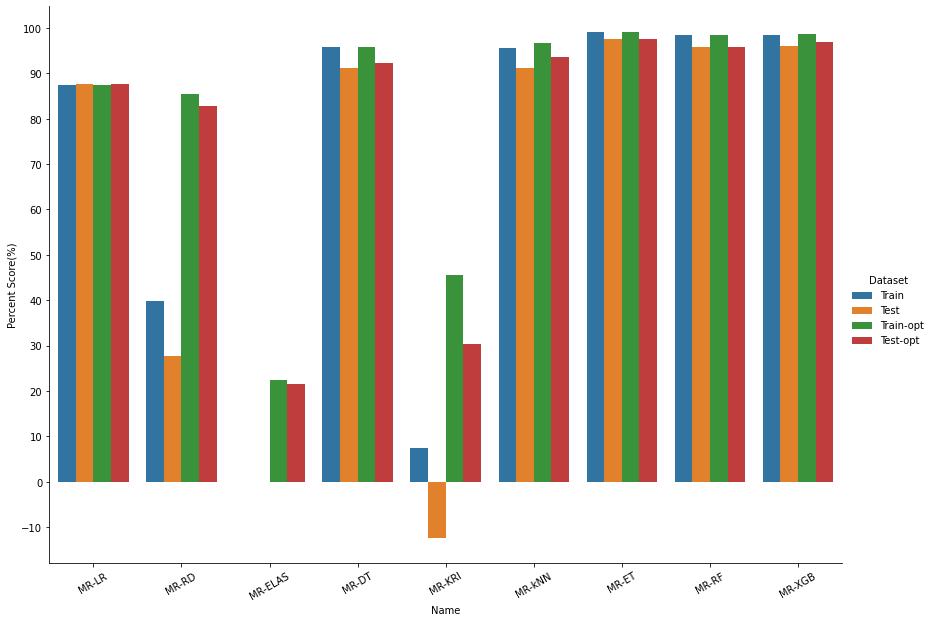

Wall time: 1min 8s


In [114]:
%%time
final_df,_ = compare_models_final(X_train,y_train,X_test,y_test,models,models_opt,models_df)

In [115]:
change = pd.DataFrame(columns=['Name','Dataset','ScoreChange'])
for i in range(0,18):
    change = change.append({'Name':final_df.Name[i],'Dataset':final_df.Dataset[i],'ScoreChange':round(final_df.Score[i+18]-final_df.Score[i],2)},ignore_index=True)
change['Per'] = 100*change['ScoreChange']
change

,Name,Dataset,ScoreChange,Per
0,MR-LR,Train,0.00,0.0
1,MR-LR,Test,-0.00,-0.0
2,MR-RD,Train,0.46,46.0
3,MR-RD,Test,0.55,55.0
4,MR-ELAS,Train,0.22,22.0
5,MR-ELAS,Test,0.21,21.0
6,MR-DT,Train,-0.00,-0.0
7,MR-DT,Test,0.01,1.0
8,MR-KRI,Train,0.38,38.0
9,MR-KRI,Test,0.43,43.0


### Πίνακας μεταβολής επίδοσης των αλγορίθμων μετά τη βελτιστοποίησή τους

Text(0.5, 0.98, 'Score Change after hyperparameter optimization for each Regressor')

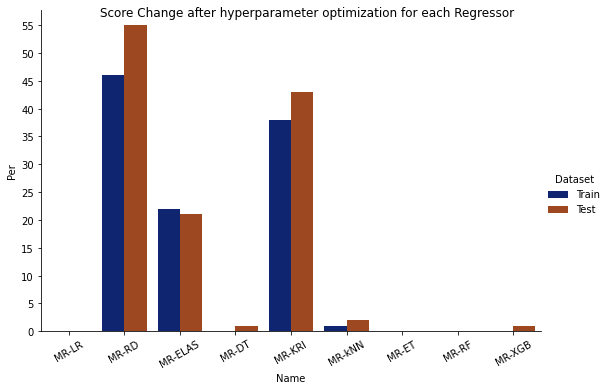

In [117]:
g = sns.catplot(x = 'Name', y='Per',hue = 'Dataset',data=change, kind='bar',height=5,aspect=1.5, palette='dark')
g.set_xticklabels(rotation=30)
g.set(yticks=np.arange(0,60,5))
g.fig.suptitle('Score Change after hyperparameter optimization for each Regressor')

# Σχόλια:

- Αρχικά έχει νόημα να αναρωτηθούμε ποια είναι η έννοια του Score ($R^2$) σε ένα πρόβλεψης δύο μεταβλητών, οπότε ανατρέξαμε στο documentation του scikit learn για τον multi output regressor: The coefficient  is defined as $(1-\frac{u}{v})$ , where $u$  is the residual sum of squares `((y_true - y_pred) ** 2).sum()` and $v$ is the total sum of squares `((y_true - y_true.mean()) ** 2).sum()`. Δηλαδή υπολογίζονται τα squared errors για κάθε πρόβλεψη και γίνεται uniform averaging.
- Όσον αφορά τους γραμμικούς regressors, παρατηρούμε ότι ο Ridge τείνει προς τον γραμμικό, χωρίς να συγκλίνει απόλυτα προς αυτόν, και ο Elastic Net όσες επαναλήψεις και να του προσθέσουμε αποτυγχάνει στη σύγκλιση, λόγω της φύσης του προβλήματος. 
- Ο Decision Trees Regressor μετά τη βελτιστοποίηση δείχνει μια μικρή αύξηση ακρίβειας της τάξης του 1\% στο test set.
- Ο Kernel Ridge Regressor μετά από την αρνητική επίδοσή του με τους default parameters δείχνει αύξηση μετά την βελτιστοποίηση, χωρίς να καταφέρνει βέβαια να πιάνει υψηλό score.
- Ο Nearest Neighbors Regressor μετά τη βελτιστοποίηση εμφανίζει 1\% αύξηση στο score για το train test και 2\% για το test set.
- Οι Regressors Extra Trees και Random Forest μετά από Grid Search δείχνουν ότι προτιμούν τις defaults υπερπαραμέτρους τους, οπότε δεν εμφανίζουν κάποια μεταβολή στα ήδη υψηλά scores τους.
- Τέλος, ο XGB μετά από τη βελτιστοποίηση εμφανίζει 1\% αύξηση score στο test set.
- Στα περισσότερα κελιά που υπάρχει ενδιαφέρον για το χρόνο εκτέλεσης έχει προστεθεί η built-in magic command `%%time` ώστε να φαίνεται ο χρόνος εκτέλεσης. Για όλους τους υπολογισμούς χρησιμοποιήθηκαν jupyter notebooks σε local runtime με επεξεργαστή i7-9th gen. Στις πιο απαιτητικές εργασίες, δηλαδή στα Grid Search, προστέθηκε η εντολή `n_jobs=-1` ώστε να εκτελούνται υπολογισμοί εν παραλλήλω, αξιοποιώντας και τα 12 threads του επεξεργαστή. 